## Policy and Value Monte Carlo Tree Search

Introduce a policy network together with the value network (if they share computations is more efficient).
Use this network to predict the prior of the child nodes, which will be used in the p-UCT formula to select them.
$$
a^* = \arg\underset{a}{\max} Q(s,a) + c P(s,a) \frac{\sqrt{\sum_b N(s,b)}}{1 + N(s,a)}
$$

whereas before I was using:
$$
a^* = \arg\underset{a}{\max} Q(s,a) + c \frac{\sqrt{\sum_b N(s,b)}}{\epsilon + N(s,a)}
$$
where the $\epsilon$ was small enough to ensure that every node (s,a) would be visited at least once before visiting twice another node with the same parent (this makes sense if we don't have a prior telling us which nodes are probably good and which are not, because in that case is more sensible to explore first in width and then in depth).

**TODO**
- add Dirichlet exploration noise to the prior for the root's children
- find out why it's so slow compared to the value MCTS

### Dirichlet exploration noise - how does it work?

Calling 
- $P^{net}(s,a)$ the prior given for action $a$ from state $s$, that is for child (s,a) of parent s;
- $Dir(a|\alpha)$ the probability allocated for the a-th value (out of |A| possible values) from the Dirichlet distribution with |A|-dimensional vector $(\alpha, \ldots, \alpha)$
- $\epsilon$ the mixing coefficient, taken as 0.25 in DeepMind experiments 

We modify the prior of the root's children nodes as:
$$P(s,a) = (1-\epsilon)P^{net}(s,a) + \epsilon Dir(a|\alpha) $$

This ensures that the prior probability of each action is non-zero.

The Dirichlet distribution is a distribution of probability mass functions (in this case over |A| possible values), which defines the probability density for each possible categorical distrbution over |A| values. 
The value of $\alpha$ controls how much variance/entropy there is on average in the categorical distributions sampled by the Dirichlet distribution (see http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/ for a blog with illustrations and code about it). If we assume all $\alpha$ equal (because we do not discriminate between possible actions a priori), we have three different regimes:
- $\alpha < 1$: we will sample mainly categorical distributions that assign high probability to one action and low to the others
- $\alpha = 1$: we will sample uniformly in the space of all categorical distributions 
- $\alpha > 1$: we will sample mainly constant noise probabilities, i.e. every action will usually receive a probability close to 1/|A|

In the papers they use $\alpha < 1$:

*Dirichlet noise Dir(α) was added to the prior
probabilities in the root node; this was scaled in inverse proportion to the approximate number
of legal moves in a typical position, to a value of α = {0.3, 0.15, 0.03} for chess, shogi and
Go respectively.* [AlphaZero]

However both the number of simulations per move and the action space were different (e.g. in chess they were respectively 800 and around 35).

Also I didn't found mention of this in the MuZero paper, but only on AlphaGo and AlphaZero.

I have the feeling that using $\alpha=1$ would be better than nothing.

### Entropy bonus
A different approach could be to change the loss in something less brittle, i.e. using an entropy bonus.

Current loss for frame/state $s$:
$$CE_{loss}(s) = - \sum_a \pi(s,a) \log P^{net}(s,a) > 0$$

Where $\pi(s,a)$ is obtained from the visit counts N(s,a) as
$$ \pi(s,a) = \frac{N(s,a)^{1/T}}{\sum_b N(s,b)^{1/T}}$$

and T is a temperature parameter that should be annealed during the training (in the last experiment I decreased it exponentially from 1.0 to 0.1)

Proposed loss:

$$
\begin{align}
L(s) &= - \sum_a \pi(s,a) \log P^{net}(s,a) + h \sum_a P^{net}(s,a) \log P^{net}(s,a) \\
& = - \sum_a [\pi(s,a) - h P^{net}(s,a)] \log P^{net}(s,a)
\end{align}
$$

with $h=0.01$ or something like that

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import train
from mcts import *
from rtfm import featurizer as X
import os

We should use the valid actions to mask out the actions that cannot be taken, so that we have a normalized probability mass function over the valid actions only.

In [2]:
class FixedDynamicsPVNet(nn.Module):
    def __init__(self, 
                 gym_env,
                 emb_dim=10,
                ):
        super().__init__()
        self.name_embedding = nn.Embedding(len(gym_env.vocab), emb_dim)
        self.inv_embedding = nn.Embedding(len(gym_env.vocab), emb_dim)
        
        name_shape = gym_env.observation_space['name']
        inv_shape = gym_env.observation_space['inv']
        n_channels = (name_shape[2]*name_shape[3]+inv_shape[0])*emb_dim
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )

        self.maxpool = nn.MaxPool2d(gym_env.observation_space['name'][1])

        self.value_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
        self.policy_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,len(gym_env.action_space))
        )
        
    def forward(self, frame):
        device = next(self.parameters()).device
        x = self.name_embedding(frame['name'].to(device))
        s = x.shape
        B, W, H = s[:3]
        x = x.reshape(*s[:3],-1).permute(0, 3, 1, 2)
        
        inv = self.inv_embedding(frame['inv'].to(device))
        inv = inv.reshape(B,-1,1,1)
        inv = inv.expand(B,-1,W,H)
        
        z = torch.cat([x,inv], axis=1)
        z_conv = self.conv_net(z)
        z_flat = self.maxpool(z_conv).view(B,-1)
        
        v = self.value_mlp(z_flat)
        logits = self.policy_mlp(z_flat)
        #print("logits: ", logits)
        action_mask = 1-frame['valid'].to(device)
        #print("action_mask: ", action_mask)
        probs = F.softmax(logits.masked_fill((action_mask).bool(), float('-inf')), dim=-1) 
        #print("probs: ", probs)
        return v, probs

In [3]:
verbose = False
vprint = print if verbose else lambda *args, **kwargs: None

In [4]:
class PriorValueNode(Node):
    def __init__(self, prior=0.):
        super().__init__()
        self.frame = None
        self.prior = prior
        self.full_action_space = None # comprehends also moves that are not allowed in the node
        
    def expand(self, frame, valid_actions, priors, reward, done, simulator):
        self.expanded = True
        vprint("Valid actions as child: ", valid_actions)
        vprint("Prior over the children: ", priors)
        vprint("Terminal node: ", done)
        self.full_action_space = len(priors) # trick to pass this information
        self.frame = frame
        self.reward = reward
        self.terminal = done
        self.valid_actions = valid_actions
        if not done:
            for action in valid_actions:
                self.children[action] = PriorValueNode(priors[action])
        self.simulator_dict = simulator.save_state_dict()
        
    def get_children_probs(self, T):
        """
        Use formula p(a) = N(a)^{1/T} / \sum_b N(b)^{1/T} to get the probabilities 
        of selecting the various actions.
        """
        
        Ns = np.zeros(self.full_action_space) # check this
        for action, child in self.children.items():
            Ns[action] = child.visit_count
        
        #print("Ns: ", Ns)
        scores = Ns**(1./T)
        #print("scores: ", scores)
        probs = scores/scores.sum()
        #print("probs: ", probs)
        return probs
    
    def sample_child(self, temperature):
        probs = self.get_children_probs(temperature)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        return action, probs

In [5]:
action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }

In [6]:
class PolicyValueMCTS(MCTS):
    def __init__(self, 
                 root_frame,
                 simulator,
                 valid_actions,
                 ucb_c,
                 discount,
                 max_actions,
                 pv_net,
                 root=None,
                 render=False):
        
        super().__init__(simulator,
                     valid_actions,
                     ucb_c,
                     discount,
                     max_actions,
                     root,
                     render)
        self.pv_net = pv_net 
        self.root_frame = root_frame
        
    def run(self, num_simulations, mode="simulate"):
        """
        Runs num_simulations searches starting from the root node corresponding to the internal
        state of the simulator given during initialization.
        Returns the root node and an extra_info dictionary
        """
        if self.root is None:
            self.root = PriorValueNode() 
            
            with torch.no_grad():
                _, root_prior = self.pv_net(self.root_frame)
                root_prior = root_prior.reshape(-1).cpu().numpy()
                # Add Dirichlet noise here - pay attention to add it only to legal actions
                
            self.root.expand(
                self.root_frame,
                self.valid_actions,
                root_prior,
                0, # reward to get to root
                False, # terminal node
                self.simulator # state of the simulator at the root node 
            )
            
            # not sure about this
            self.root.visit_count += 1
        
        max_tree_depth = 0
        root = self.root
        for n in range(num_simulations):
            ### Start of a simulation/search ###
            vprint("\nSimulation %d started."%(n+1))
            node = root
            # make sure that the simulator internal state is reset to the original one
            self.simulator.load_state_dict(root.simulator_dict)
            search_path = [node]
            current_tree_depth = 0
            if self.render:
                node.render(self.simulator)
            ### Selection phase until leaf node is reached ###
            while node.expanded or (current_tree_depth<self.max_actions):
                current_tree_depth += 1
                action, node = self.select(node)
                if self.render and node.expanded:
                    node.render(self.simulator)
                vprint("Current tree depth: ", current_tree_depth)
                vprint("Action selected: ", action, action_dict[action])
                vprint("Child node terminal: ", node.terminal)
                vprint("Child node expanded: ", node.expanded)
                if node.expanded or node.terminal:
                    search_path.append(node)
                    if node.terminal:
                        break
                else:
                    break
                
            ### Expansion of leaf node (if not terminal)###
            vprint("Expansion phase started")
            if not node.terminal:
                parent = search_path[-1] # last expanded node on the search path
                node = self.expand(node, parent, action)
                if self.render:
                    node.render(self.simulator)
                search_path.append(node)
            
            ### Simulation phase for self.max_actions - current_tree_depth steps ###
            vprint("Value prediction/simulation phase started")
            if mode=="simulate":
                value = self.simulate(node, current_tree_depth)
            elif mode=="predict":
                value = self.predict(node)
            elif mode=="simulate_and_predict":
                value = self.simulate_and_predict(node, current_tree_depth)
            elif mode =="hybrid":
                value1 = self.simulate(node, current_tree_depth)
                value2 =self.predict(node)
                value = 0.5*value1 + 0.5*value2
            else:
                raise Exception("Mode "+mode+" not implemented.")
            vprint("Predicted/simulated value: ", value)
            
            ### Backpropagation of the leaf node value along the seach_path ###
            vprint("Backpropagation phase started")
            self.backprop(search_path, value)
        
            max_tree_depth = max(max_tree_depth, current_tree_depth)
            vprint("Simulation %d done."%(n+1))
        extra_info = {
            "max_tree_depth": max_tree_depth
        }
        # just a check to see if root works as a shallow copy of self.root
        assert root.visit_count == self.root.visit_count, "self.root not updated during search"
        
        # make sure that the simulator internal state is reset to the original one
        self.simulator.load_state_dict(root.simulator_dict)
        return root, extra_info
    
    def ucb_score(self, parent, child):
        """
        The score for a node is based on its value, plus an exploration bonus.
        """
        exploration_term = self.ucb_c*child.prior*np.sqrt(np.log(parent.visit_count)/(child.visit_count+1))

        if child.visit_count > 0:
            # Mean value Q
            value_term = child.reward + self.discount*child.value() 
        else:
            value_term = 0

        return value_term + exploration_term, value_term, exploration_term
    
    def expand(self, node, parent, action):
        """
        Expand the node obtained by taking the given action from the parent node 
        """
        simulator = parent.get_simulator(self.simulator) # get a deepcopy of the simulator with the parent's state stored
        frame, valid_actions, reward, done = simulator.step(action) # this also updates the simulator's internal state
        with torch.no_grad():
            value, prior = self.pv_net(frame)
            prior = prior.reshape(-1).cpu().numpy()
        vprint("valid_actions: ", valid_actions)
        vprint("prior: ", prior)
        vprint("reward: ", reward)
        vprint("done: ", done)
        node.expand(frame, valid_actions, prior, reward, done, simulator)
        return node
    
    def predict(self, node):
        if not node.terminal:
            with torch.no_grad():
                value, _ = self.pv_net(node.frame)
                value = value.item()
        else:
            value = 0
        return value
    
    def simulate(self, node, current_depth):
        """
        Simulate a rollout with a random policy starting from the input node
        until the end of the episode or self.max_actions are reached 
        (also considering the current depth of the input node from the root)
        """
        if not node.terminal:
            simulator = node.get_simulator(self.simulator)
            valid_actions = node.valid_actions
            steps = self.max_actions - current_depth
            cum_discounted_reward = 0
            for i in range(steps):
                action = np.random.choice(valid_actions)
                frame, valid_actions, reward, done = simulator.step(action)
                cum_discounted_reward += (self.discount**i)*reward
                if done:
                    break
        else:
            cum_discounted_reward = 0
        return cum_discounted_reward
    
    def simulate_and_predict(self, node, current_depth, n_steps=5):
        """
        Simulate a rollout with a random policy starting from the input node
        until the end of the episode or self.max_actions are reached 
        (also considering the current depth of the input node from the root)
        or at most n_steps before calling the value_net to approximate the rest of the trajectory.
        """
        if not node.terminal:
            simulator = node.get_simulator(self.simulator)
            valid_actions = node.valid_actions
            steps = min(self.max_actions, n_steps) # FIX THIS
            cum_discounted_reward = 0
            for i in range(steps):
                action = np.random.choice(valid_actions)
                frame, valid_actions, reward, done = simulator.step(action)
                cum_discounted_reward += (self.discount**i)*reward
                if done:
                    break
            if not done:
                with torch.no_grad():
                    value, _ = self.pv_net(node.frame)
                    bootstrap_value = value.item()
                cum_discounted_reward += (self.discount**steps)*bootstrap_value
        else:
            cum_discounted_reward = 0
        return cum_discounted_reward

In [7]:
def play_episode_policy_value_net(
    pv_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    temperature,
    object_ids,
    mode="simulate",
    render = False,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    probs_lst = []
    reward_lst = []
    done_lst = []
    action_is_optimal = []
    for i in range(episode_length):
        tree = PolicyValueMCTS(
                             frame, 
                             env, 
                             valid_actions, 
                             ucb_C, 
                             discount, 
                             max_actions, 
                             pv_net,
                             render=debug_render, 
                             root=new_root
                             )
        print("Performing MCTS step")
        root, info = tree.run(num_simulations, mode=mode)
        #show_root_summary(root, discount)
        print("Tree info: ", info)
        action, probs = root.sample_child(temperature)
        probs_lst.append(probs) # shape (A,)
        print("probs from MCTS: ", probs)
        print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        
        # Evaluate chosen action against optimal policy
        best_actions = utils.get_optimal_actions(frame, object_ids)
        print("Best actions: ", best_actions, [action_dict[a] for a in best_actions])
        if action in best_actions:
            action_is_optimal.append(True)
        else:
            action_is_optimal.append(False)
            
        new_root = tree.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
        print("Reward received: ", reward)
        print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal

In [8]:
def play_rollout_policy_value_net(
    pv_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    temperature,
    object_ids,
    mode="simulate",
    bootstrap="no",
    render = False,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    # variables used for training of value net
    frame_lst = [frame]
    probs_lst = []
    reward_lst = []
    done_lst = []
    action_is_optimal = []
    for i in range(episode_length):
        tree = PolicyValueMCTS(
                             frame, 
                             env, 
                             valid_actions, 
                             ucb_C, 
                             discount, 
                             max_actions, 
                             pv_net,
                             render=debug_render, 
                             root=new_root
                             )
        #print("Performing MCTS step")
        root, info = tree.run(num_simulations, mode=mode)
        #show_root_summary(root, discount)
        #print("Tree info: ", info)
        action, probs = root.sample_child(temperature)
        probs_lst.append(probs) # shape (A,)
        #print("probs from MCTS: ", probs)
        #print("Action selected from MCTS: ", action, "({})".format(action_dict[action]))
        # Evaluate chosen action against optimal policy
        best_actions = utils.get_optimal_actions(frame, object_ids)
        #print("Best actions: ", best_actions, [action_dict[a] for a in best_actions])
        if action in best_actions:
            action_is_optimal.append(True)
        else:
            action_is_optimal.append(False)
            
        new_root = tree.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        frame_lst.append(frame)
        reward_lst.append(reward)
        done_lst.append(done)
        
        if render:
            env.render()
        #print("Reward received: ", reward)
        #print("Done: ", done)
        total_reward += reward
        
        if done:
            frame, valid_actions = env.reset()
            if render:
                print("\nNew episode begins.")
                env.render()
            done = False
            new_root = None

    if not done_lst[-1]:
        if bootstrap=="no":
            pass
        elif bootstrap=="root_value":
            reward_lst[-1] = new_root.value()
        elif bootstrap=="value_net":
            reward_lst[-1] = value_net(new_root.frame).item()
        else:
            raise Exception("Value of bootstrap variable should be one of 'no','root_value' and 'value_net'.")
    action_is_optimal = np.array(action_is_optimal, dtype=np.float)
    return total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal

In [9]:
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 6
max_actions = 5
num_simulations = 100
temperature = 1.

flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = FullTrueSimulator(gym_env, featurizer)
net = FixedDynamicsPVNet(gym_env)
object_ids = utils.get_object_ids_dict(game_simulator)

In [10]:
results = play_episode_policy_value_net(
    net,
    game_simulator,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    temperature,
    object_ids,
    mode="simulate",
    render = True,
    debug_render=False
)


██████
█ @  █
█ !  █
█?   █
█n  y█
██████

Performing MCTS step
Tree info:  {'max_tree_depth': 8}
probs from MCTS:  [0.05 0.   0.01 0.92 0.02]
Action selected from MCTS:  3 (Left)
Best actions:  [4] ['Right']

██████
█@   █
█ !  █
█?   █
█n  y█
██████

Reward received:  0
Done:  False
Performing MCTS step


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Tree info:  {'max_tree_depth': 7}
probs from MCTS:  [0.28795812 0.         0.0104712  0.         0.70157068]
Action selected from MCTS:  4 (Right)
Best actions:  [4] ['Right']

██████
█ @  █
█ !  █
█?   █
█n  y█
██████

Reward received:  0
Done:  False
Performing MCTS step
Tree info:  {'max_tree_depth': 7}
probs from MCTS:  [0.02575107 0.         0.00429185 0.06008584 0.90987124]
Action selected from MCTS:  4 (Right)
Best actions:  [4] ['Right']

██████
█  @ █
█ !  █
█?   █
█n  y█
██████

Reward received:  0
Done:  False
Performing MCTS step
Tree info:  {'max_tree_depth': 7}
probs from MCTS:  [0.31189711 0.         0.03536977 0.00643087 0.64630225]
Action selected from MCTS:  4 (Right)
Best actions:  [4, 2] ['Right', 'Down']

██████
█   @█
█ !  █
█?   █
█n  y█
██████

Reward received:  0
Done:  False
Performing MCTS step
Tree info:  {'max_tree_depth': 6}
probs from MCTS:  [0.38666667 0.         0.38666667 0.22666667 0.        ]
Action selected from MCTS:  0 (Stay)
Best actions:  [2] ['

In [11]:
total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal = results

In [12]:
print("Percentage of optimal actions: %.1f %%"%(np.mean(action_is_optimal)*100))

Percentage of optimal actions: 50.0 %


In [27]:
results = play_rollout_policy_value_net(
    net,
    game_simulator,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    temperature,
    object_ids,
    mode="simulate",
    render = True,
    debug_render=False
)


██████
█ y  █
█   !█
█ @  █
█?  n█
██████


██████
█ y  █
█   !█
█ @  █
█?  n█
██████


██████
█ y  █
█   !█
█@   █
█?  n█
██████


██████
█ y  █
█@  !█
█    █
█?  n█
██████


██████
█@y  █
█   !█
█    █
█?  n█
██████


██████
█ @  █
█   !█
█    █
█?  n█
██████
gleaming sword

██████
█    █
█ @ !█
█    █
█?  n█
██████
gleaming sword


In [28]:
total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal = results

## Developing the training cycle for the policy

In [13]:
class PolicyReplayBuffer:
    def __init__(self, mem_size):
        self.mem_size = mem_size
        self.frame_buffer = []
        self.probs_buffer = []
    
    def store_episode(self, frame_lst, probs_lst):
        frames, probs = self.batch_episode(frame_lst, probs_lst)
        self.frame_buffer.append(frames)
        self.probs_buffer.append(probs)
        if len(self.frame_buffer) > self.mem_size:
            self.frame_buffer.pop(0)
            self.probs_buffer.pop(0)
            
    def batch_episode(self, frame_lst, probs_lst):
        episode_len = len(reward_lst)
        frames = {}
        for k in frame_lst[0].keys():
            k_value_lst = []
            for b in range(episode_len): # this is a problem, since the frame_lst has one more state!!!
                k_value_lst.append(frame_lst[b][k])
            k_value_lst = torch.cat(k_value_lst, axis=0)
            frames[k] = k_value_lst.unsqueeze(0)
            
        probs = torch.tensor(probs_lst).float() # (T, A)
        
        return frames, probs.unsqueeze(0) #(1,T,A)
    
    def get_batch(self, batch_size):
        id_range = len(self.probs_buffer)
        assert id_range >= batch_size, "Not enough samples stored to get this batch size"
        sampled_ids = np.random.choice(id_range, size=batch_size, replace=False)
        sampled_probs = torch.cat([self.probs_buffer[i] for i in sampled_ids], axis=0)
        # batch together frames 
        sampled_frames = {}
        for k in self.frame_buffer[0].keys():
            key_values = torch.cat([self.frame_buffer[i][k] for i in sampled_ids], axis=0)
            sampled_frames[k] = key_values
            
        reshaped_frames = {}
        for k in sampled_frames.keys():
            shape = sampled_frames[k].shape
            reshaped_frames[k] = sampled_frames[k].reshape(-1,*shape[2:])
        
        reshaped_probs = sampled_probs.reshape(-1, sampled_probs.shape[-1]) #(B*T, A)
        return reshaped_frames, reshaped_probs

In [14]:
def compute_policy_update(pv_net, frames, target_probs, optimizer):
    
    target_probs = target_probs.to(device)
    #print("target_probs: \n", target_probs)
    mask = (target_probs==0)
    #print("mask: ", mask)
    values, probs = pv_net(frames) # (B*T, A)
    #print("probs: \n", probs)
    # regularize nan, since they won't contribute anyways because the target prob is 0
    probs = torch.clamp(probs, 1e-9, 1 - 1e-9)
    log_probs = torch.log(probs)
    #print("log_probs: \n", log_probs)
    loss = -(target_probs*log_probs).sum(axis=1).mean() # cross-entropy averaged over batch dim
    #print("loss: \n", loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [15]:
def plot_losses(losses):
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel("Number of optimizer steps", fontsize=16)
    plt.ylabel("Policy net cross entropy loss", fontsize=16)
    plt.show()
    
def plot_rewards(total_rewards):
    window = 20
    average_rewards = np.array([np.mean(total_rewards[i-window:i]) for i in range(window, len(total_rewards))])
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(average_rewards)), average_rewards, label="Moving average over %d rollouts"%window)
    plt.xlabel("Number of rollouts", fontsize=16)
    plt.ylabel("Average total reward in 32 steps", fontsize=16)
    plt.legend()
    plt.show()
    
def plot_action_optimality(perc_optimal_actions):
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(perc_optimal_actions)), perc_optimal_actions)
    plt.xlabel("Number of optimizer steps", fontsize=16)
    plt.ylabel("Fraction of optimal actions per trajectory", fontsize=16)
    plt.show()

In [25]:
# Check only if main logic of the training loop works
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 100
device = device
n_episodes = 2000
memory_size = 528
batch_size = 32
n_steps = 5
tau = 0.5 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params
temperature = 1.

training_params = dict(
    ucb_C = 1.0,
    discount = 0.9,
    episode_length = 32,
    max_actions = 5,
    num_simulations = 100,
    device = device,
    n_episodes = 2000,
    memory_size = 528,
    batch_size = 32,
    n_steps = 5,
    tau = 0.5,
    temperature = 1.
)

In [26]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = FullTrueSimulator(gym_env, featurizer)
object_ids = utils.get_object_ids_dict(game_simulator)

pv_net = FixedDynamicsPVNet(gym_env).to(device)
        
optimizer = torch.optim.Adam(pv_net.parameters(), lr=1e-3)
gamma = 10**(-2/(n_episodes-1)) # decrease lr of 2 order of magnitude during training
gamma_T = 10**(-1/(n_episodes-1)) # decrease temperature of 1 order of magnitude during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
rb = PolicyReplayBuffer(memory_size)

In [27]:
ID = "policy_AAA"

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█? @ █
█    █
██████

██████
█!   █
█    █
█?   █
█  @ █
██████

██████
█!   █
█    █
█?   █
█   @█
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█?   █
█   @█
██████

██████
█!   █
█    █
█?   █
█   @█
██████

██████
█!   █
█    █
█?   █
█   @█
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!  @█
█    █
█?   █
█    █
██████

██████
█!  @█
█    █
█?   █
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█    █
█?  @█
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!   █
█   @█
█?   █
█    █
██████

██████
█!  

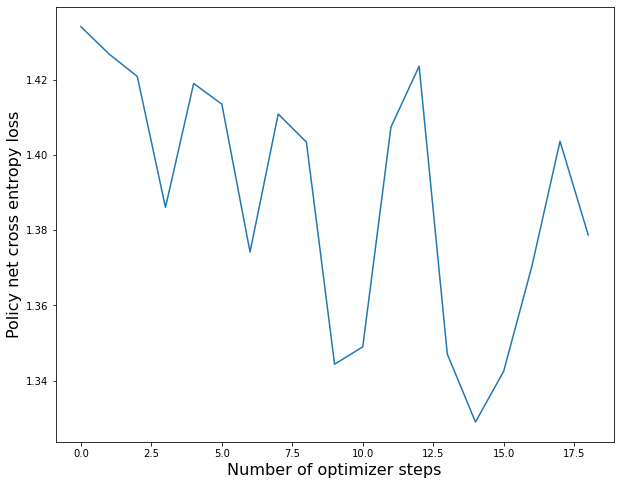

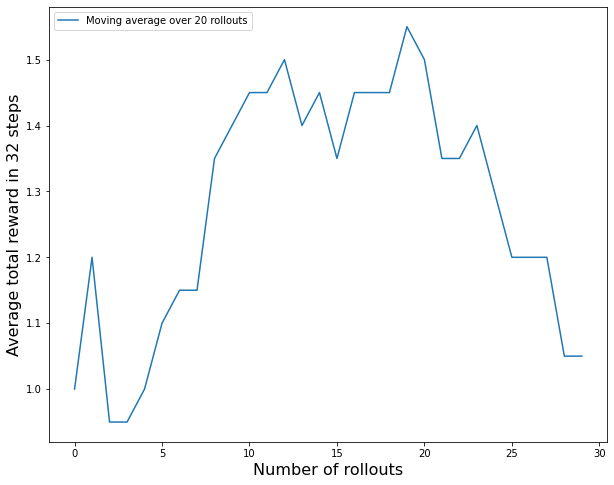

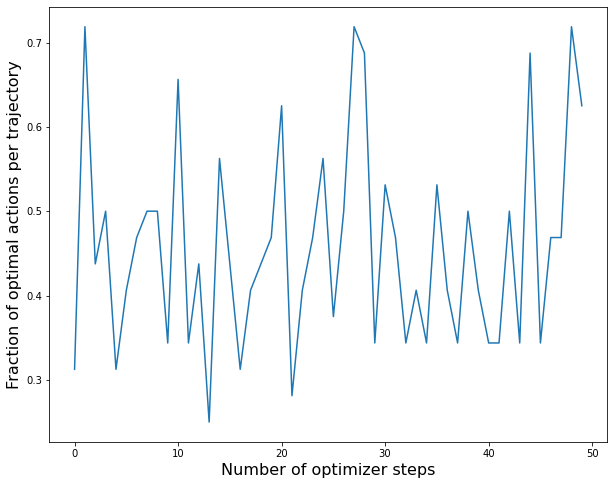


Episode 51 - Total reward 1 
Rollout time: 0.43
Loss: 1.4303

Episode 52 - Total reward 2 
Rollout time: 1.07
Loss: 1.4089

Episode 53 - Total reward 1 
Rollout time: 0.47
Loss: 1.4234

Episode 54 - Total reward 1 
Rollout time: 0.53
Loss: 1.3946

Episode 55 - Total reward 2 
Rollout time: 0.29
Loss: 1.4153

Episode 56 - Total reward 3 
Rollout time: 0.26
Loss: 1.3917

Episode 57 - Total reward 1 
Rollout time: 0.42
Loss: 1.3486

Episode 58 - Total reward 0 
Rollout time: 0.50
Loss: 1.4244

Episode 59 - Total reward 1 
Rollout time: 0.38
Loss: 1.4169

Episode 60 - Total reward 2 
Rollout time: 0.35
Loss: 1.3760

Episode 61 - Total reward 1 
Rollout time: 0.39
Loss: 1.3875

Episode 62 - Total reward 2 
Rollout time: 0.32
Loss: 1.3604

Episode 63 - Total reward 0 
Rollout time: 0.50
Loss: 1.3471

Episode 64 - Total reward 1 
Rollout time: 0.50
Loss: 1.3271

Episode 65 - Total reward 1 
Rollout time: 0.45
Loss: 1.4097

Episode 66 - Total reward 1 
Rollout time: 0.39
Loss: 1.3835

Episode

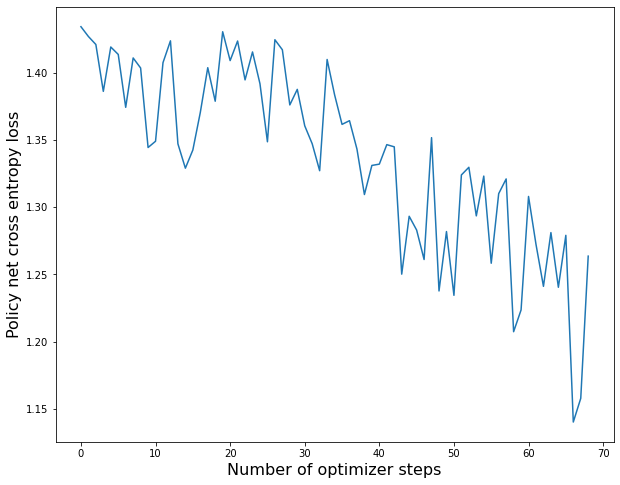

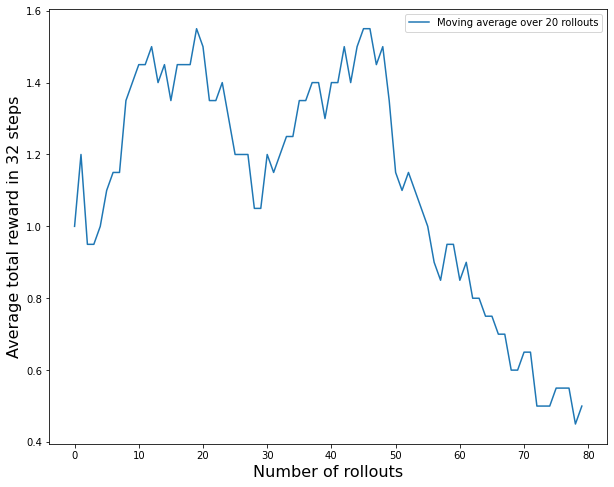

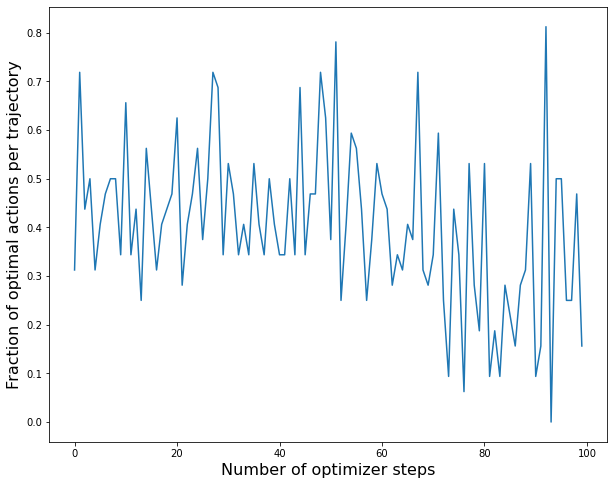

/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-04-tf2/1b2b24f2/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FixedDynamicsPVNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved checkpoint.

Episode 101 - Total reward 2 
Rollout time: 0.44
Loss: 1.2230

Episode 102 - Total reward 0 
Rollout time: 0.85
Loss: 1.2802

Episode 103 - Total reward 0 
Rollout time: 0.51
Loss: 1.1267

Episode 104 - Total reward 0 
Rollout time: 0.51
Loss: 1.1836

Episode 105 - Total reward 0 
Rollout time: 0.58
Loss: 1.0883

Episode 106 - Total reward 0 
Rollout time: 0.50
Loss: 1.1593
██████
█  ! █
█    █
█?   █
█  @ █
██████

██████
█  ! █
█    █
█?   █
█   @█
██████

██████
█  ! █
█    █
█?   █
█   @█
██████

██████
█  ! █
█    █
█?   █
█   @█
██████

██████
█  ! █
█    █
█?   █
█   @█
██████

██████
█  ! █
█    █
█?   █
█  @ █
██████

██████
█  ! █
█    █
█?   █
█  @ █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█ @  █
██████

██████
█  ! █
█    █
█?   █
█  @ █
██████

██

In [ ]:
%%time
total_rewards = []
perc_optimal_actions = []
losses = []
for i in range(n_episodes):
    ### Generate experience ###
    t0 = time.time()
    #modes = ["simulate", "predict", "simulate_and_predict"]
    modes=["simulate"]
    mode = np.random.choice(modes)
    #target_net.eval()
    results = play_rollout_policy_value_net(pv_net,
                                            game_simulator,
                                            episode_length,
                                            ucb_C,
                                            discount,
                                            max_actions,
                                            num_simulations,
                                            temperature,
                                            object_ids,
                                            mode=mode,
                                            bootstrap="no"
                                            )
    total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal = results
    t1 = time.time()
    total_rewards.append(total_reward)
    perc_optimal_actions.append(np.mean(action_is_optimal))
    print("\nEpisode %d - Total reward %d "%(i+1, total_reward))
    rollout_time = (t1-t0)/60
    print("Rollout time: %.2f"%(rollout_time))
    rb.store_episode(frame_lst, probs_lst)
    # decrease the temperature for action selection from visit counts
    temperature = temperature*gamma_T
    
    ### Train pv_net ###

    try:
        # update value network all the time
        #target_net.eval()
        frames, probs = rb.get_batch(batch_size)
        #value_net.train()
        loss = compute_policy_update(pv_net, frames, probs, optimizer)
        scheduler.step()
        # update target network only from time to time
        #if (i+1)%8==0:
        #    train.update_target_net(target_net, value_net, tau)
        print("Loss: %.4f"%loss)
        losses.append(loss)

    except:
        pass

    if (i+1)%50==0:
        # Print update
        print("\nAverage reward over last 50 rollouts: %.2f\n"%(np.mean(total_rewards[-50:])))
        print("Percentage of optimal actions: %.1f %%"%(np.mean(perc_optimal_actions[-50:])*100))
        plot_losses(losses)
        plot_rewards(total_rewards)
        plot_action_optimality(perc_optimal_actions)
        
    if (i+1)%100==0:
        # Save checkpoint
        #target_net.eval()
        #value_net.eval()
        d = dict(
            episodes_played=i,
            training_params=training_params,
            object_ids=object_ids,
            pv_net=pv_net,
            #target_net=target_net,
            rb=rb,
            losses=losses,
            total_rewards=total_rewards,
            perc_optimal_actions=perc_optimal_actions
        )

        if not os.path.isdir('./save_dir/'+ID+'/'):
            os.mkdir('./save_dir/'+ID+'/')
        torch.save(d, './save_dir/'+ID+'/training_dict_%d'%(i+1))
        print("Saved checkpoint.")

## Building the optimal policy (see utils)

In [13]:
frame, valid_moves = game_simulator.reset()

In [14]:
game_simulator.render()


██████
█  ? █
█ n  █
█ y@!█
█    █
██████



In [15]:
frame["name"][0,:,:,0,0]

tensor([[  3,   3,   3,   3,   3,   3],
        [  3, 170, 170, 180, 170,   3],
        [  3, 170, 198, 170, 170,   3],
        [  3, 170, 200, 183, 179,   3],
        [  3, 170, 170, 170, 170,   3],
        [  3,   3,   3,   3,   3,   3]])

In [46]:
object_ids = utils.get_object_ids_dict(game_simulator)
object_ids

{'target_monster': 179,
 'distractor_monster': 180,
 'agent': 183,
 'yes_item': 200,
 'no_item': 198}

## Test 1: only initial frames

In [28]:
for i in range(100):
    frame, valid_moves = game_simulator.reset()
    game_simulator.render()
    optimal_actions = get_optimal_actions(frame, object_ids)
    print("Best actions: ", [action_dict[a] for a in optimal_actions])
    print("_"*40)


██████
█    █
█   y█
█n   █
█! ?@█
██████

initial_pos:  tensor([[3, 4]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(2) tensor(10)
Best actions:  ['Up']
________________________________________

██████
█!   █
█  n?█
█   y█
█@   █
██████

initial_pos:  tensor([[3, 1],
        [4, 2]])
optimal_moves:  tensor([True, True])
extra_distance:  0
d_min, d_max:  tensor(4) tensor(8)
Best actions:  ['Up', 'Right']
________________________________________

██████
█    █
█!   █
█@  y█
█n ? █
██████

initial_pos:  tensor([[3, 2]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(3) tensor(7)
Best actions:  ['Right']
________________________________________

██████
█n   █
█ ?@ █
█    █
█y ! █
██████

initial_pos:  tensor([[3, 3]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(4) tensor(8)
Best actions:  ['Down']
________________________________________

██████
█ n !█
█@ ? █
█    █
█y   █
██████

initial_pos:  tensor([[3, 1


██████
█ n  █
█y   █
█    █
█ ?@!█
██████

initial_pos:  tensor([[3, 3]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(4) tensor(8)
Best actions:  ['Up']
________________________________________

██████
█?   █
█n  @█
█    █
█!  y█
██████

initial_pos:  tensor([[3, 4]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(2) tensor(8)
Best actions:  ['Down']
________________________________________

██████
█    █
█ ! y█
█? n █
█@   █
██████

initial_pos:  tensor([[4, 2]])
optimal_moves:  tensor([True])
extra_distance:  0
d_min, d_max:  tensor(5) tensor(7)
Best actions:  ['Right']
________________________________________

██████
█    █
█    █
█@ ?!█
█ n y█
██████

initial_pos:  tensor([[3, 2],
        [4, 1]])
optimal_moves:  tensor([True, True])
extra_distance:  0
d_min, d_max:  tensor(4) tensor(8)
Best actions:  ['Right', 'Down']
________________________________________

██████
█    █
█ @ y█
█    █
█!?n █
██████

initial_pos:  tensor([[2, 


██████
█   ?█
█  @ █
█ ny █
█!   █
██████

Best actions:  ['Down']
________________________________________

██████
█y  n█
█ @! █
█   ?█
█    █
██████

initial_pos:  tensor([[1, 2],
        [2, 1]])
optimal_moves:  tensor([True, True])
extra_distance:  0
d_min, d_max:  tensor(2) tensor(10)
Best actions:  ['Up', 'Left']
________________________________________

██████
█!   █
█    █
█?@  █
█ny  █
██████

Best actions:  ['Down']
________________________________________

██████
█    █
█ y  █
█!?n █
█@   █
██████

initial_pos:  tensor([[4, 2]])
optimal_moves:  tensor([False])
initial_pos:  tensor([[4, 2]])
optimal_moves:  tensor([False])
initial_pos:  tensor([[4, 2]])
optimal_moves:  tensor([True])
extra_distance:  2
d_min, d_max:  tensor(3) tensor(9)
Best actions:  ['Right']
________________________________________

██████
█ y  █
█@ n █
█  ? █
█!   █
██████

initial_pos:  tensor([[1, 1],
        [2, 2]])
optimal_moves:  tensor([True, True])
extra_distance:  0
d_min, d_max:  tensor(2) tens

## Test 2: percentage of episodes solved

- 97.2 % of games solved with this policy (there are some initial conditions which trap the agent in a corner between the two monsters and are unsolvable).
- Average reward in 32 steps: 5.09 (this is one of the targets that we should aim for with our training)

In [40]:
rewards = []
episode_length = 32
for i in range(1000):
    render = False
    if i < 10:
        print("-"*40)
        print("Episode %d"%(i+1))
        render=True
    total_reward = utils.play_episode_optimal_policy(game_simulator, episode_length, object_ids, render=render)
    if render:
        print("Final score: ", total_reward, "\n")
    rewards.append(total_reward)
print("\nPercentage of game solved: %.2f"%(np.mean(rewards)*100))

----------------------------------------
Episode 1

██████
█n   █
█?   █
█!  y█
█  @ █
██████

Best actions:  ['Up', 'Right']

██████
█n   █
█?   █
█!  y█
█   @█
██████

Best actions:  ['Up']

██████
█n   █
█?   █
█!  @█
█    █
██████
gleaming sword
Best actions:  ['Left']

██████
█n   █
█?   █
█! @ █
█    █
██████
gleaming sword
Best actions:  ['Left']

██████
█n   █
█?   █
█!@  █
█    █
██████
gleaming sword
Best actions:  ['Left']

██████
█n   █
█?   █
█@   █
█    █
██████
gleaming sword
Final score:  1 

----------------------------------------
Episode 2

██████
█  ?!█
█    █
█ @  █
█y  n█
██████

Best actions:  ['Left', 'Down']

██████
█  ?!█
█    █
█@   █
█y  n█
██████

Best actions:  ['Down']

██████
█  ?!█
█    █
█    █
█@  n█
██████
gleaming sword
Best actions:  ['Up', 'Right']

██████
█  ?!█
█    █
█    █
█ @ n█
██████
gleaming sword
Best actions:  ['Up', 'Right']

██████
█  ?!█
█    █
█    █
█  @n█
██████
gleaming sword
Best actions:  ['Up']

██████
█  ?!█
█    █
█  @ █
█   

In [42]:
rewards = []
episode_length = 32
for i in range(1000):
    render = False
    if i < 10:
        print("-"*40)
        print("Episode %d"%(i+1))
        render=True
    total_reward = utils.play_episode_optimal_policy(game_simulator, episode_length, object_ids, render=render, reset_if_done=True)
    if render:
        print("Final score: ", total_reward, "\n")
    rewards.append(total_reward)
print("\nAverage reward in %d steps: %.2f"%(episode_length, np.mean(rewards)))

----------------------------------------
Episode 1

██████
█  ? █
█ y n█
█  @ █
█   !█
██████

Best actions:  ['Up', 'Left']

██████
█  ? █
█ y@n█
█    █
█   !█
██████

Best actions:  ['Left']

██████
█  ? █
█ @ n█
█    █
█   !█
██████
gleaming sword
Best actions:  ['Right', 'Down']

██████
█  ? █
█   n█
█ @  █
█   !█
██████
gleaming sword
Best actions:  ['Right', 'Down']

██████
█  ? █
█   n█
█    █
█ @ !█
██████
gleaming sword
Best actions:  ['Right']

██████
█  ? █
█   n█
█    █
█  @!█
██████
gleaming sword
Best actions:  ['Right']

██████
█  ? █
█   n█
█    █
█   @█
██████
gleaming sword
Best actions:  ['Left', 'Down']

██████
█    █
█y@  █
█    █
█!?n █
██████

Best actions:  ['Left']

██████
█    █
█@   █
█    █
█!?n █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█    █
█@   █
█!?n █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█    █
█    █
█@?n █
██████
gleaming sword
Best actions:  ['Up', 'Right']

██████
█! ?n█
█  y █
█ @  █
█    █
██████

Best


██████
█ @! █
█ n  █
█  ? █
█    █
██████
gleaming sword
Best actions:  ['Right']

██████
█  @ █
█ n  █
█  ? █
█    █
██████
gleaming sword
Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█    █
█  @!█
█ n?y█
██████

Best actions:  ['Stay']

██████
█    █
█   

Best actions:  ['Right']

██████
█ @ y█
█  ! █
█ ?  █
█    █
██████
grandmasters sword
Best actions:  ['Right']

██████
█  @y█
█  ! █
█ ?  █
█    █
██████
grandmasters sword
Best actions:  ['Right']

██████
█   @█
█  ! █
█ ?  █
█    █
██████
gleaming sword
Best actions:  ['Left', 'Down']

██████
█  @ █
█  ! █
█ ?  █
█    █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█  @ █
█ ?  █
█    █
██████
gleaming sword
Best actions:  ['Up', 'Right']

██████
█  @y█
█?  n█
█   !█
█    █
██████

Best actions:  ['Right']

██████
█   @█
█?  n█
█   !█
█    █
██████
gleaming sword
Best actions:  ['Left']

██████
█  @ █
█?  n█
█   !█
█    █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█? @n█
█   !█
█    █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█?  n█
█  @!█
█    █
██████
gleaming sword
Best actions:  ['Right']

██████
█    █
█?  n█
█   @█
█    █
██████
gleaming sword
Best actions:  ['Right']

██████
█    █
█ @y!█
█    █
█ ?  █
██████
grandmasters swo


██████
█    █
█ @ n█
█?   █
█!   █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█   n█
█?@  █
█!   █
██████
gleaming sword
Best actions:  ['Down']

██████
█    █
█   n█
█?   █
█!@  █
██████
gleaming sword
Best actions:  ['Left']

██████
█    █
█   n█
█?   █
█@   █
██████
gleaming sword
Best actions:  ['Right']

██████
█ !  █
█ ?  █
█   @█
█ n  █
██████
gleaming sword
Best actions:  ['Up', 'Left']

██████
█ !  █
█ ?  █
█  @ █
█ n  █
██████
gleaming sword
Best actions:  ['Up']

██████
█ !  █
█ ?@ █
█    █
█ n  █
██████
gleaming sword
Best actions:  ['Up']

██████
█ !@ █
█ ?  █
█    █
█ n  █
██████
gleaming sword
Best actions:  ['Left']

██████
█ @  █
█ ?  █
█    █
█ n  █
██████
gleaming sword
Best actions:  ['Left', 'Down']

██████
█!   █
█? @ █
█ y  █
█n   █
██████

Best actions:  ['Left', 'Down']

██████
█!   █
█?@  █
█ y  █
█n   █
██████

Best actions:  ['Down']

██████
█!   █
█?   █
█ @  █
█n   █
██████
gleaming sword
Final score:  6 


Average reward in 32 steps: 5.